<a href="https://colab.research.google.com/github/francisconetodata/portfolio_python/blob/main/pmc_valor_ibge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio - Análise Macro

Autor: Francisco de Assis Pereira Neto

Data: 16/09/2021

## Passo 1: Algortimo de imporação dos dados automatizado

Pacotes necessários:


*   urllib3 - Necessário para realizar o request com o site do IBGE. O link foi coletado no site do IBGE.
*   json - Necessário para manupular extrair o arquivo json com os dados que serão importados;
*   Os demais pacotes manipulam dados e fazem visualizações, principalmente, datas que serão fundamentais nessa situação.





In [58]:
import urllib3
import json
import matplotlib.pyplot as plt
import numpy
from datetime import date

In [59]:
# Ano, mês e dia : Hoje!
data_atual = date.today()
atual = data_atual.strftime('%Y%m')
atual_s = int(atual)
data_atual

datetime.date(2021, 9, 16)

In [60]:
# Fragmentos e junção do url que fará download dos dados no período de análise
# O while atualiza o url de modo a buscar a última data.
url_1 = 'https://servicodados.ibge.gov.br/api/v3/agregados/3416/periodos/200001'
verificador = url_1[-6:]
verificador = int(verificador)
url_2 = ''
mes = 1
ano = 2000
while (verificador<atual_s):
  if (mes==13):
    mes = 1
    ano = ano + 1
    verificador = str(ano)+ '0' + str(mes)
  url_2 = url_2 + "|" + str(verificador)
  verificador = url_2[-6:]
  verificador = int(verificador) + 1
  mes = mes +1 
url_3 = '/variaveis/564?localidades=N1[all]&classificacao=11046[40311]'
url_complete = url_1+url_2+url_3
# Formação do url completo que busca de janeiro de 2000 ao último mês que saiu.
# url_complete

In [61]:
# Faz o request com o link e busca a informação:
http = urllib3.PoolManager() 
urlPortalApiIBGE = url_complete
response = http.request('GET',urlPortalApiIBGE)
print("Response Status:", response.status)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning:

Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



Response Status: 200


In [62]:
# Decodificação das informações em UTF-8:
data_response = response.data.decode('utf-8')
# data_response

In [63]:
# Carregando arquivo json:
data_json = json.loads(data_response)
# data_json 

In [64]:
# Extraindo a série temporal PCM - IBGE nacional
dados = data_json[0]
dados = dados['resultados']
dados = dados[0]
dados = dados['series']
dados = dados[0]
dados = dados['serie']
# print(dados)

## Criação do dataframe com pandas

In [65]:
# Criação do dataframe resultante:
import pandas as pd
pmc = pd.DataFrame.from_dict(dados, orient='index').rename(columns={0:'pmc_valor'})
pmc.pmc_valor = pmc.pmc_valor.astype(float)
# pmc

In [66]:
# Sumário dos valores da série temporal do PMC Nacional
pmc.describe()

,pmc_valor
count,259.000000
mean,76.139382
std,21.216095
min,42.800000
25%,53.650000
50%,81.700000
75%,91.800000
max,130.300000


In [67]:
# importar pacotes e setar configurações de plots
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

### Manipulação das datas, colocando como índice do dataframe.

In [68]:
data_final = str(pmc.index[-1])
data_final

'202107'

In [69]:
data_inicial = str(pmc.index[0])
data_inicial

'200001'

In [70]:
date_1 = '{}--{}'.format(str(data_inicial[4:6]),str(data_inicial[0:4]))
date_2 = '{}--{}'.format(str(data_final[4:6]),str(data_final[0:4]))
date_2

'07--2021'

In [71]:
pmc.shape[0]

259

In [72]:
pd.date_range(date_1, periods=pmc.shape[0], freq='M')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31'],
              dtype='datetime64[ns]', length=259, freq='M')

In [73]:
pmc.index = pd.date_range(date_1, periods=pmc.shape[0], freq='M')
indices = pmc.index
# indices

In [74]:
# Comando para salvar o arquivo em csv
# pmc.to_csv('pmc.csv')

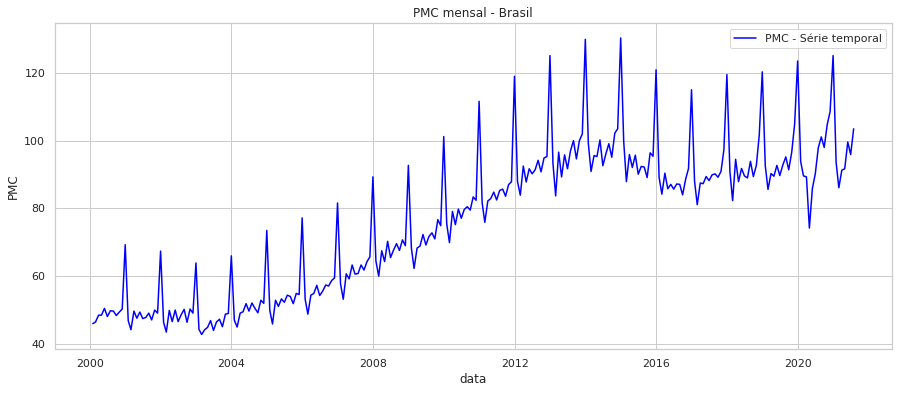

In [75]:
plt.figure(figsize=(15, 6))
plt.title("PMC mensal - Brasil")
plt.plot(pmc,label="PMC - Série temporal",color="blue")
plt.xlabel("data")
plt.ylabel("PMC")
plt.legend()
# Para Salvar a imagem
# plt.savefig('pmcserie.png', format='png')

Ao observar e analisar visualmente o gráfico da série temporal, é possível observar uma padrão de sazonalidade e de tendência de alta e depois de estabilização. De certo modo, seria interessante aplicar um modelo ARIMA para ajustar um modelo mais simples em relação a modelos mais robustos, como as regressões via machine learning.

Morettin (2018) relata que o modelo ARIMA consiste na análise de modelos paramêtricos. Essa metodologia consiste no ajuste de modelos autoregressivos atrlados ao cálculo de médias móveis e é apelidado de ARIMA (p,d,q).

Existe uma sequência para encontrar o melhor modelo ARIMA. De acordo com Morettin (2018), o ciclo é iterativo e formado pelas seguintes etapas:


1.   Escolhe-se o modelo ARIMA e, em seguida, é feita uma análise das autocorrelações, autocorrelações parciais e outros;
2.   Estima-se os parâmetros (p,d,q) do modelo;
3.   Por fim, faz-se análise dos resíduos, para ver se eventualmente é interessante para uma previsão.

Morettin (2018) mostra também a existência do modelo SARIMA. Esse modelo leva em conta eventos sazonais, como é possível observar na séries do PMC Nacional. No python, o pacote que faz a verificação do modelo, calculando o AIC, que consiste no critério de informação de Akaike, que minimiza o valor de AIC.



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



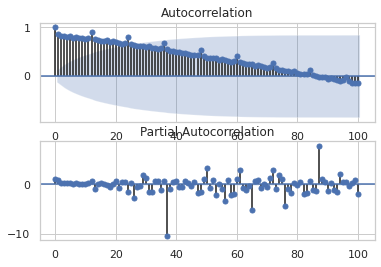

In [76]:
# Gráficos de autocorrelação e de autocorrelação parcial
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
N_LAGS = 100
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1)
plot_acf(pmc.pmc_valor, ax=ax[0], lags=N_LAGS,alpha=SIGNIFICANCE_LEVEL)
plot_pacf(pmc.pmc_valor, ax=ax[1], lags=N_LAGS,alpha=SIGNIFICANCE_LEVEL)
plt.show()

<Figure size 1080x1080 with 0 Axes>

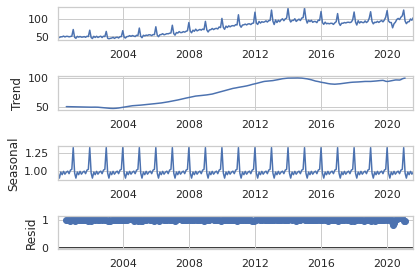

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
analysis = pmc
decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
plt.figure(figsize=(15, 15))
decompose_result_mult.plot()
# Para salvar a imagem>
# plt.savefig('decompose.png', format='png')
plt.show()

In [78]:
!pip install pmdarima

In [79]:

# Importação das bibliotecas
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from datetime import datetime
#registro de converters para uso do matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [80]:
# Implementação do auto arima para descoberta automática dos parâmetros
# A função trace = True faz o auto_arima mostrar a tabela de tentativas.
modelo_auto = auto_arima(analysis['pmc_valor'], m = 12, seasonal = True, trace = True)
# Mostra o processo iterativo de escolha do melhor valor:

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1143.711, Time=1.85 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1429.080, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1166.105, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1295.085, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1493.494, Time=0.04 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=1141.714, Time=1.34 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=1177.363, Time=0.47 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=1143.711, Time=2.95 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=1147.490, Time=1.29 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=1145.696, Time=3.43 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1142.735, Time=1.11 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1142.333, Time=1.49 sec
 ARIMA(3,0,2)(0,1,1)[12] intercept   : AIC=1142.409, Time=2.61 sec
 ARIMA(2,0,3)(0,1,1)[12] intercept   : AIC=1143.226, Time=1.66 sec
 ARIMA(1,0,1)(0,1,1

In [81]:
# Sumário do melhor modelo arima:
modelo_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  259
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -563.857
Date:                              Thu, 16 Sep 2021   AIC                           1141.714
Time:                                      10:18:39   BIC                           1166.279
Sample:                                           0   HQIC                          1151.604
                                              - 259                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1438      0.105      1.366      0.172      -0.062       0.350
ar.L1          0.2500      0.147      1.706      0.088      -0.037       0.537
ar.L2          0.6910      0.139      4.965      0.000       0.418       0.964
ma.L1          0.3978      0.141      2.818      0.005       0.121       0.674
ma.L2         -0.3866      0.065     -5.906      0.000      -0.515      -0.258
ma.S.L12      -0.4745      0.044    -10.742      0.000      -0.561      -0.388
sigma2         5.5287      0.353     15.645      0.000       4.836       6.221
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               452.35
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               5.50   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

O melhor modelo considerando a minimização do AIC é o SARIMA((2,0,2)(0,1,1)) com período 12. Lembrando que foi considerado no modelo o período da sazonalidade de 12 meses. Também, é possível observar mais estatísticas presentes no modelo. Bueno (2018) mostra que o teste Ljung-Box é voltado para determinar se as autocorrelações multivariadas são nulas, ou seja, mede a presença de correlação entre dados do mesmo mês em diversos anos. 

A estatística do Ljung-Box é 0.05, que é o mesmo do intervalo de confiança. Com isso, podemos considerar que o modelo corrigiu os efeitos de sazonalidade e, por consequência, não prejudica a análise dos resíduos.

In [82]:
from datetime import datetime, timedelta
proximos_24 = modelo_auto.predict(n_periods = 24)
# Visualização dos próximos 24 valores
data_final_c = date.today()- timedelta(days=30)
futuro = pd.DataFrame({'Valor Predito':proximos_24}, index=pd.date_range(data_final_c, periods=24, freq='M'))
futuro

,Valor Predito
2021-08-31,105.828887
2021-09-30,102.012510
2021-10-31,107.750831
2021-11-30,113.084657
2021-12-31,131.127843
2022-01-31,100.647765
2022-02-28,93.932113
2022-03-31,98.025322
2022-04-30,93.849875
2022-05-31,101.524803


In [83]:
#Somente do valor predito:
futuro.describe()

,Valor Predito
count,24.000000
mean,105.971360
std,9.968531
min,93.849875
25%,100.484651
50%,104.012755
75%,108.857845
max,134.068810


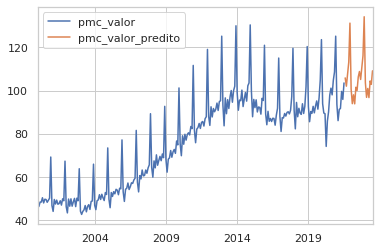

In [84]:
# Realizando a predição e plotando no gráfico, vê-se que o modelo
# Segue uma aparente continuidade no padrão apresentado, com leve aumento.

data_final_c = date.today()- timedelta(days=30)
future_forecast = pd.DataFrame({'pmc_valor_predito':proximos_24}, index=pd.date_range(data_final_c, periods=24, freq='M'))
previsao = pd.concat([analysis,future_forecast],axis=1).plot()


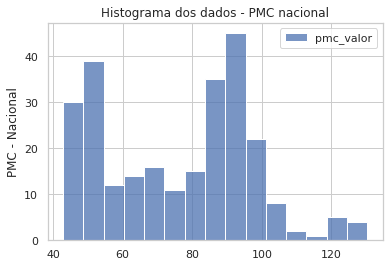

In [85]:
# Histograma de todos os valores do PMC nacional.
sns.histplot(analysis[['pmc_valor']], bins=15, color='purple')
plt.ylabel('PMC - Nacional')
plt.title('Histograma dos dados - PMC nacional')
plt.xlabel(None)
plt.xticks()
plt.savefig('histograma.png', format='png')

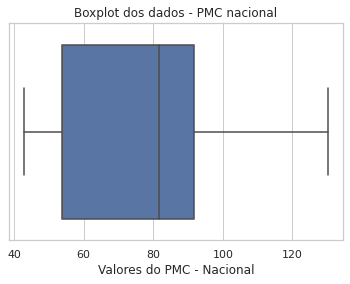

In [86]:
# Boxplot de todos os valores do PMC nacional.

sns.set_theme(style="whitegrid")
plt.title('Boxplot dos dados - PMC nacional')
ax = sns.boxplot(x=analysis["pmc_valor"])
plt.xlabel('Valores do PMC - Nacional')
plt.savefig('boxplot.png', format='png')

# Referências bibliográficas

Morettin, Pedro A. Análise de Séries Temporais. Disponível em: Minha Biblioteca, Editora Blucher, 2018.


Bueno, Rodrigo De Losso da S. Econometria de Séries Temporais - 2ª edição revista e atualizada. Disponível em: Minha Biblioteca, (2nd edição). Cengage Learning Editores SA de CV, 2018.

